In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

Criando o dataset e obtendo suas colunas

In [4]:
math = pd.read_csv('student-mat.csv')

In [5]:
math.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

As variáveis categóricas passarão por "label encoder" antes de serem submetidas a clusterização.
Porém, para formação dos clusters serão utilizadas apenas as variáveis originalmente numéricas ou as categóricas binárias.

In [6]:
# Variáveis categóricas
catFeatures = math.select_dtypes('object').columns.to_list()
math[catFeatures].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


#### Antes de efetuar o "Clustering" será feito uma transformação nos atributos de forma a torná-los numéricos, utilizando a técnica de "label encoding".

Sabe-se que para atributos categóricos não-binários, essa não é a melhor forma de codificação e, portanto, utilizará-se apenas os atributos categóricos binários na clusterização, além dos atributos já numéricos.

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
# Criando cópia dos dados
mathModificada = math.copy()
# Criando o LabelEncoder
label_encoder = LabelEncoder()
# Alterando as colunas categóricas
for col in catFeatures:
    mathModificada[col] = label_encoder.fit_transform(math[col])

In [9]:
# Duplo cheque
mathModificada.select_dtypes('object').columns.to_list()

[]

Comparação entre tabela antes e depois do "Label Encoding"

In [10]:
math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [11]:
mathModificada.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


#### Unindo fatores relacionados a: (1) comportamento com relação aos estudos; (2) aspectos familiares; (3) aspectos sociais/pessoais;  e (4) agrupamento com os atributos que mais afetam o desempenho nas provas

Antes, porém, será feita a normalização dos valores das faltas, para se reduzir o impacto de poucos valores muito altos.

In [14]:
mathModificada['absences_normalized'] =(mathModificada['absences'] - 
                                        mathModificada['absences'].mean(axis=0)) / mathModificada['absences'].std(axis=0)

In [15]:
# Agrupando fatores relacionados
estudo = ['paid','activities','nursery','studytime','failures','absences_normalized']
familiares = ['famsize','Medu','Fedu','famrel','famsup','Pstatus']
sociais = ['Walc','Dalc','goout','romantic','freetime','health']
geral = ['paid','activities','nursery','studytime','failures','absences_normalized',
                   'Walc','Dalc','goout','romantic','freetime','health']
geral = ['failures','absences','Mjob','reason','schoolsup','paid']
clusters = ["Cluster_estudo","Cluster_familiares","Cluster_sociais",'Cluster_geral']

In [16]:
# Criando os clusters de alunos baseado em cada conjunto de características
from sklearn.cluster import KMeans
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, n_init = 10, random_state=0)
mathModificada["Cluster_estudo"] = kmeans.fit_predict(mathModificada[estudo])
mathModificada["Cluster_familiares"] = kmeans.fit_predict(mathModificada[familiares])
mathModificada["Cluster_sociais"] = kmeans.fit_predict(mathModificada[sociais])
mathModificada['Cluster_geral'] = kmeans.fit_predict(mathModificada[geral])

In [17]:
mathModificada[clusters].head()

,Cluster_estudo,Cluster_familiares,Cluster_sociais,Cluster_geral
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0


Plotando a quantidade alunos pertencentes a cada cluster criado

Text(0.5, 1.0, 'Clusterização geral')

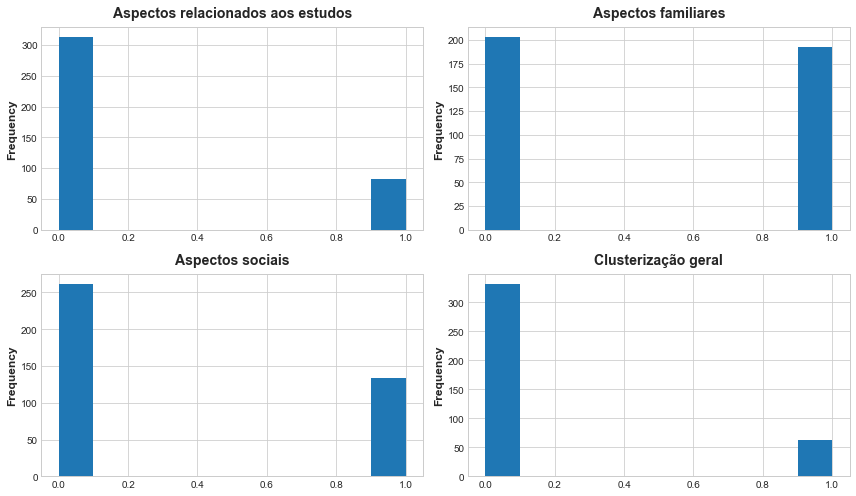

In [18]:
# Plotando os três gráficos na mesma figura
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

mathModificada['Cluster_estudo'].plot(kind = 'hist', ax = axs[0][0])
axs[0][0].set_title('Aspectos relacionados aos estudos')

mathModificada['Cluster_familiares'].plot(kind = 'hist', ax = axs[0][1])
axs[0][1].set_title('Aspectos familiares')

mathModificada['Cluster_sociais'].plot(kind = 'hist', ax = axs[1][0])
axs[1][0].set_title('Aspectos sociais')

mathModificada['Cluster_geral'].plot(kind = 'hist', ax = axs[1][1])
axs[1][1].set_title('Clusterização geral')


#### Avaliando se os agrupamentos criados ajudam a prever o desempenho dos alunos

Efeito dos aspectos acadêmicos

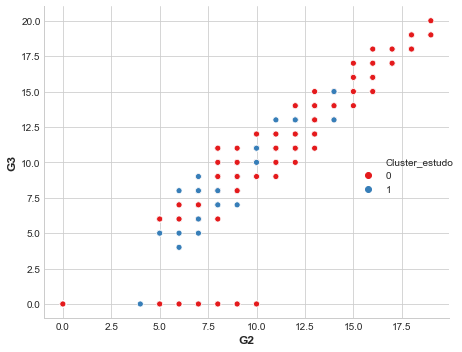

In [19]:
# Efeito dos aspectos relacionados a estudo
sns.relplot(x="G2", y="G3",hue = 'Cluster_estudo',data=mathModificada,
            palette = sns.color_palette('Set1', n_colors = n_clusters))

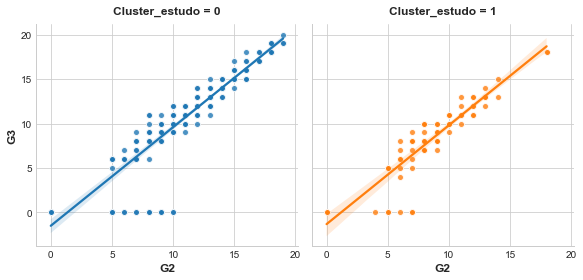

In [20]:
sns.lmplot(
    x='G2', y="G3", hue="Cluster_estudo", col="Cluster_estudo",
    data=mathModificada, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)

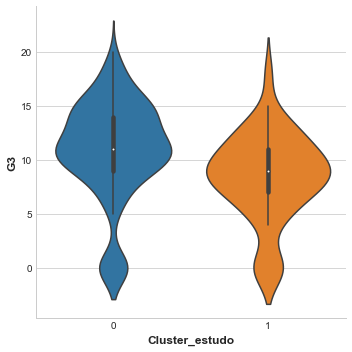

In [21]:
sns.catplot(x="Cluster_estudo", y="G3", data=mathModificada, kind="violin");

Efeito doas aspectos relacionados à família

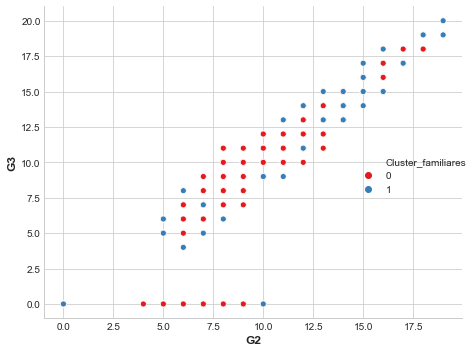

In [22]:
# Efeito dos aspectos relacionados à familia
sns.relplot(x="G2", y="G3",hue = 'Cluster_familiares',data=mathModificada,
            palette = sns.color_palette('Set1', n_colors = n_clusters))

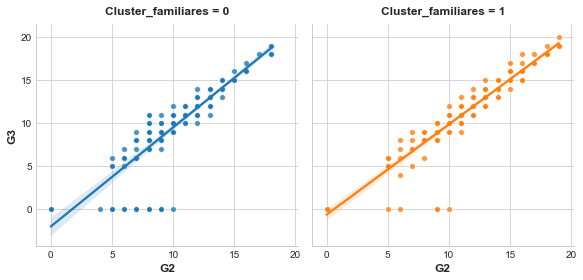

In [23]:
sns.lmplot(
    x='G2', y="G3", hue="Cluster_familiares", col="Cluster_familiares",
    data=mathModificada, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)

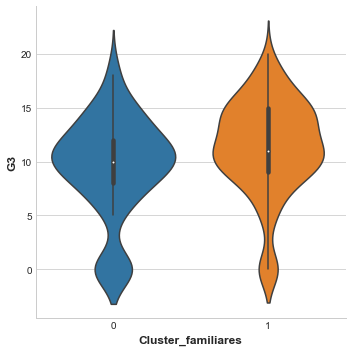

In [24]:
sns.catplot(x="Cluster_familiares", y="G3", data=mathModificada, kind="violin");

Efeito dos aspectos sociais

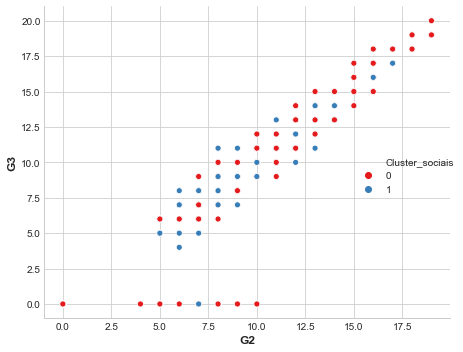

In [25]:
# Efeito dos aspectos sociais
sns.relplot(x="G2", y="G3",hue = 'Cluster_sociais',data=mathModificada,
            palette = sns.color_palette('Set1', n_colors = n_clusters))

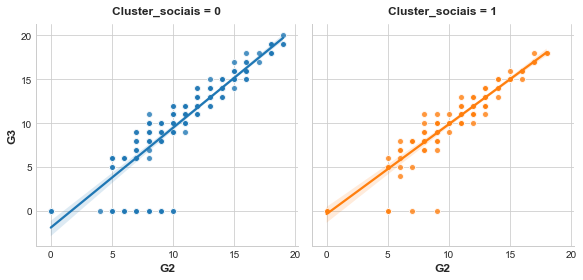

In [26]:
sns.lmplot(
    x='G2', y="G3", hue="Cluster_sociais", col="Cluster_sociais",
    data=mathModificada, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)

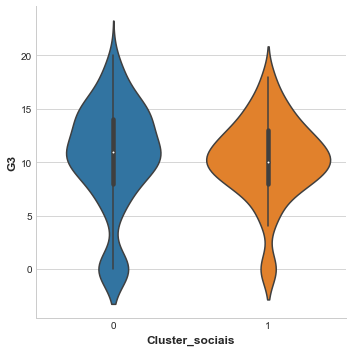

In [27]:
sns.catplot(x="Cluster_sociais", y="G3", data=mathModificada, kind="violin");

Clusterização geral 

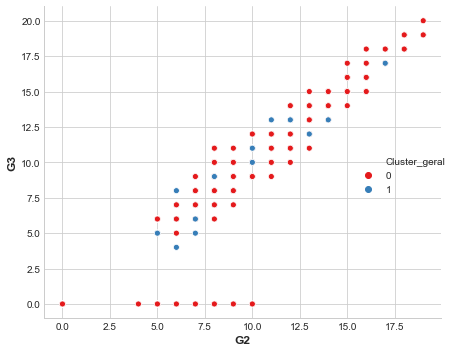

In [28]:
# Efeito dos aspectos relacionados a estudo
sns.relplot(x="G2", y="G3",hue = 'Cluster_geral',data=mathModificada,
            palette = sns.color_palette('Set1', n_colors = n_clusters))

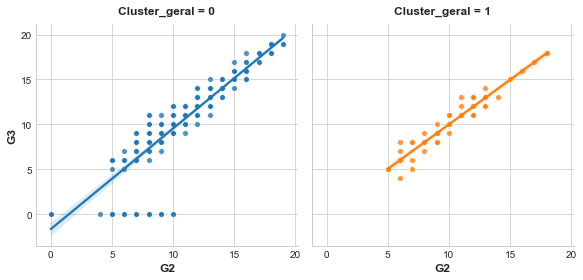

In [29]:
sns.lmplot(
    x='G2', y="G3", hue="Cluster_geral", col="Cluster_geral",
    data=mathModificada, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)

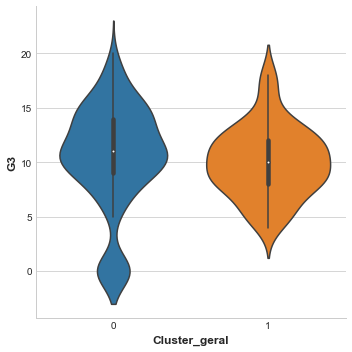

In [30]:
sns.catplot(x="Cluster_geral", y="G3", data=mathModificada, kind="violin");

#### Procurando entender o perfil do aluno de cada Cluster

Cluster de aspectos sociais

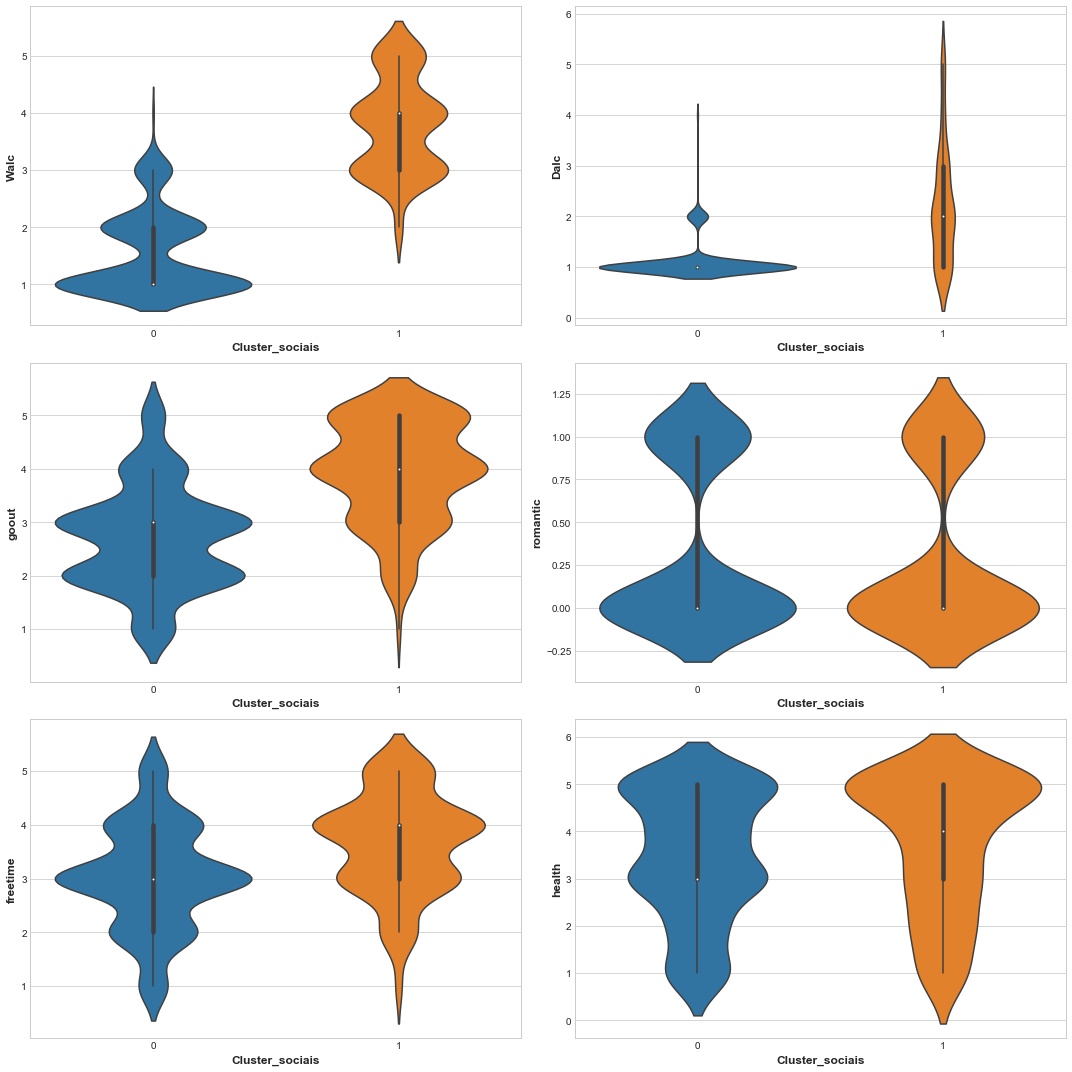

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
estudo = ['paid','activities','nursery','studytime','failures','absences_normalized']

indice = 0
for i in range(3):
    for j in range(2):
        sns.violinplot(x=mathModificada['Cluster_sociais'],
                      y=mathModificada[sociais[indice]], ax = axs[i][j])
        indice = indice + 1

Cluster de aspectos familiares

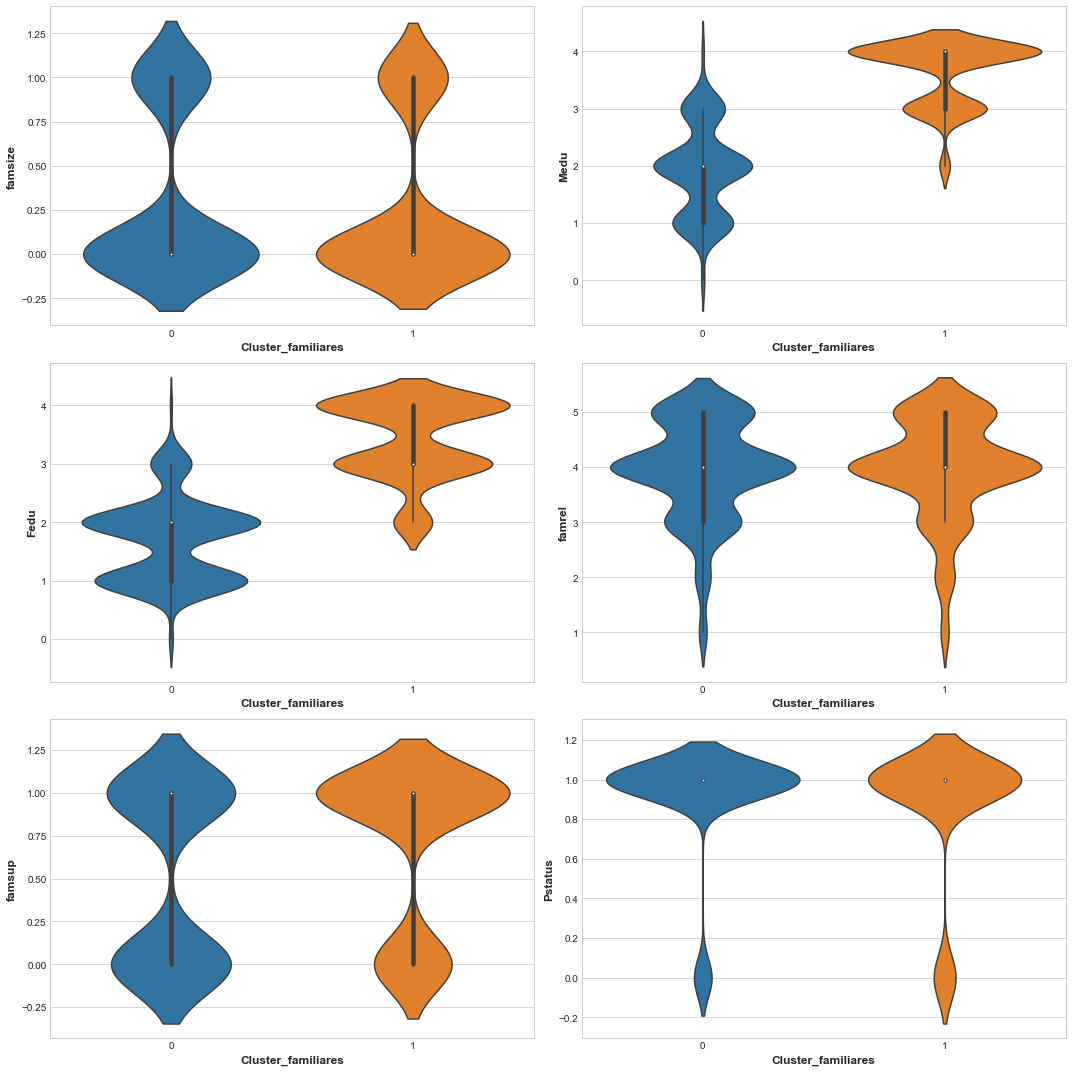

In [39]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

indice = 0
for i in range(3):
    for j in range(2):
        sns.violinplot(x=mathModificada['Cluster_familiares'],
                      y=mathModificada[familiares[indice]], ax = axs[i][j])
        indice = indice + 1

Cluster de aspectos acadêmicos

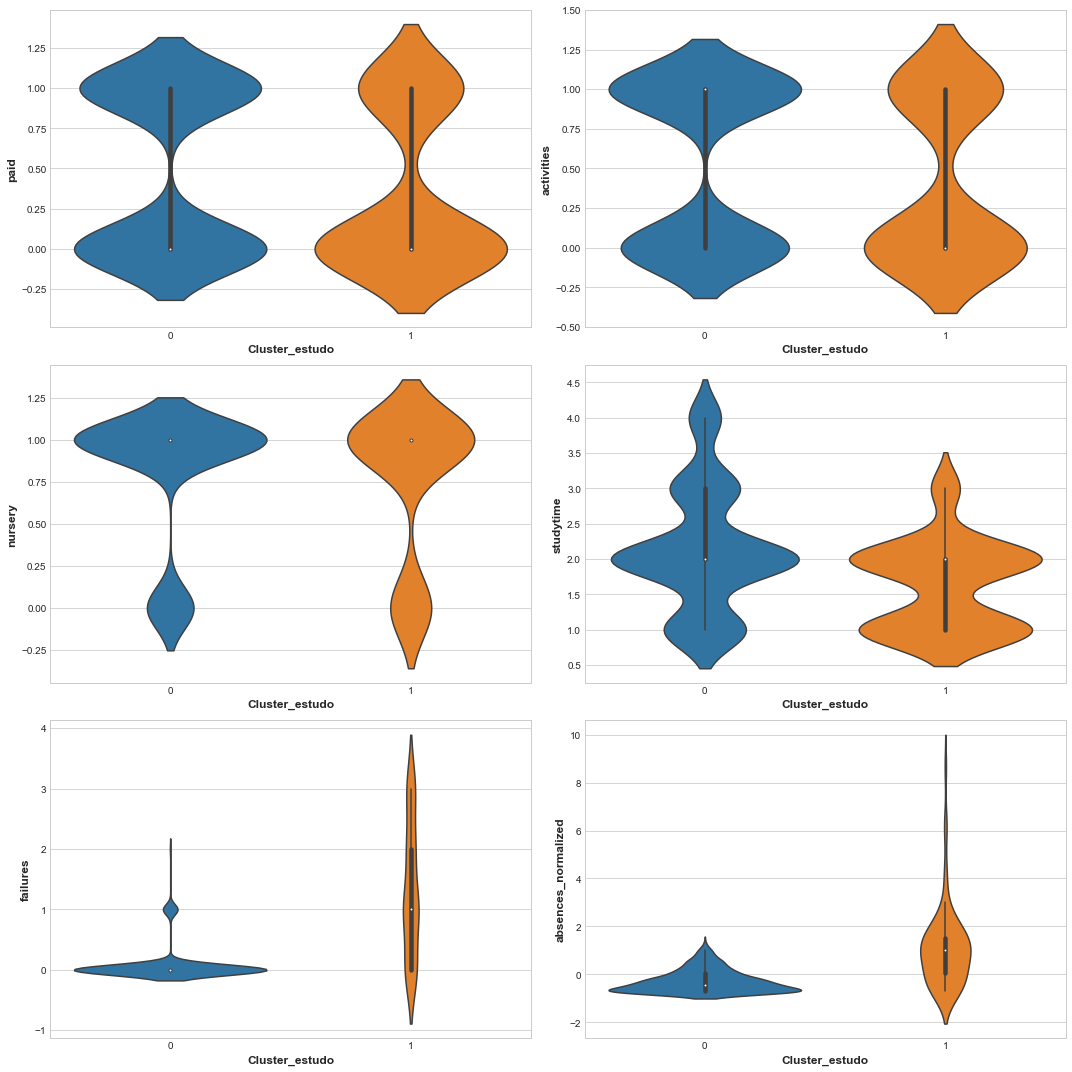

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

indice = 0
for i in range(3):
    for j in range(2):
        sns.violinplot(x=mathModificada['Cluster_estudo'],
                      y=mathModificada[estudo[indice]], ax = axs[i][j])
        indice = indice + 1

#### Mapa de calor para averiguar distinções dentre os clusters

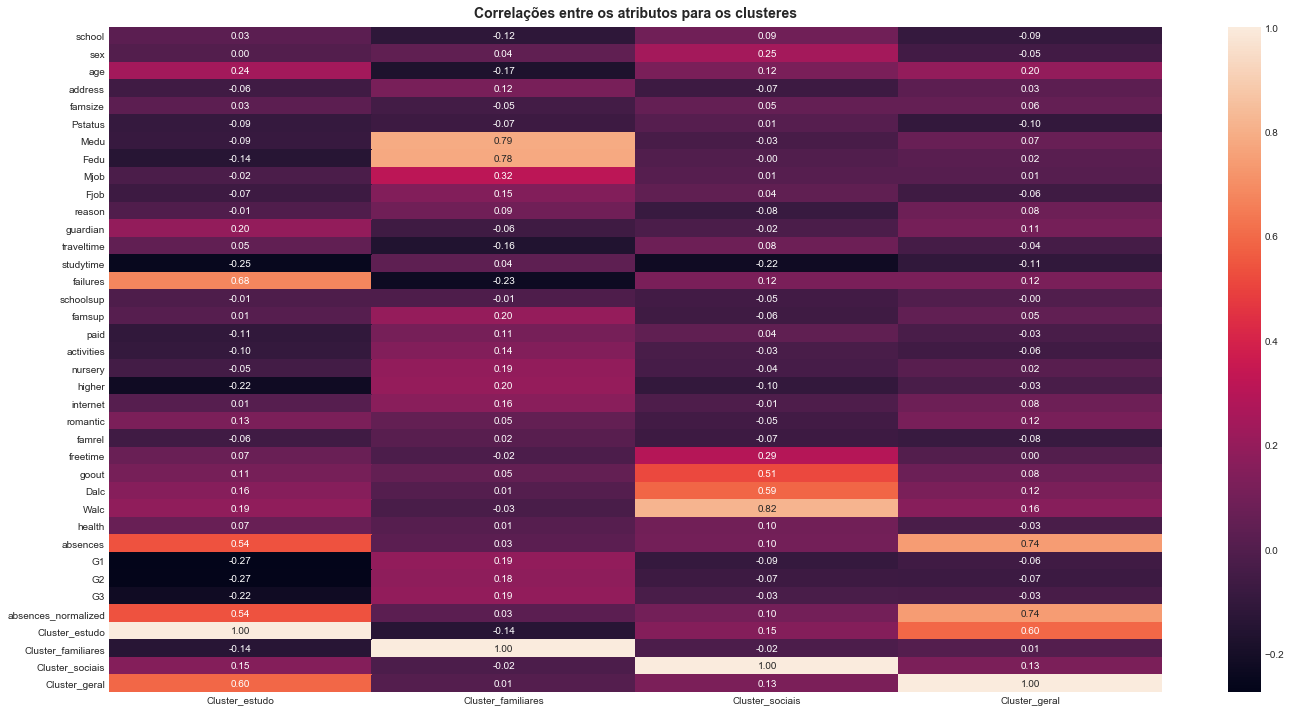

In [34]:
correlacoes = mathModificada.corr()

# Plotando a matriz
plt.figure(figsize=(20,10))
sns.heatmap(correlacoes[clusters],annot = True, fmt = ".2f")
plt.title("Correlações entre os atributos para os clusteres")
plt.show()

Gerando uma tabela com os atributos cluster para ser utilizada em outros notebooks

In [35]:
mathModificada.to_excel('Math modificada com clusters.xlsx')

#### Fim